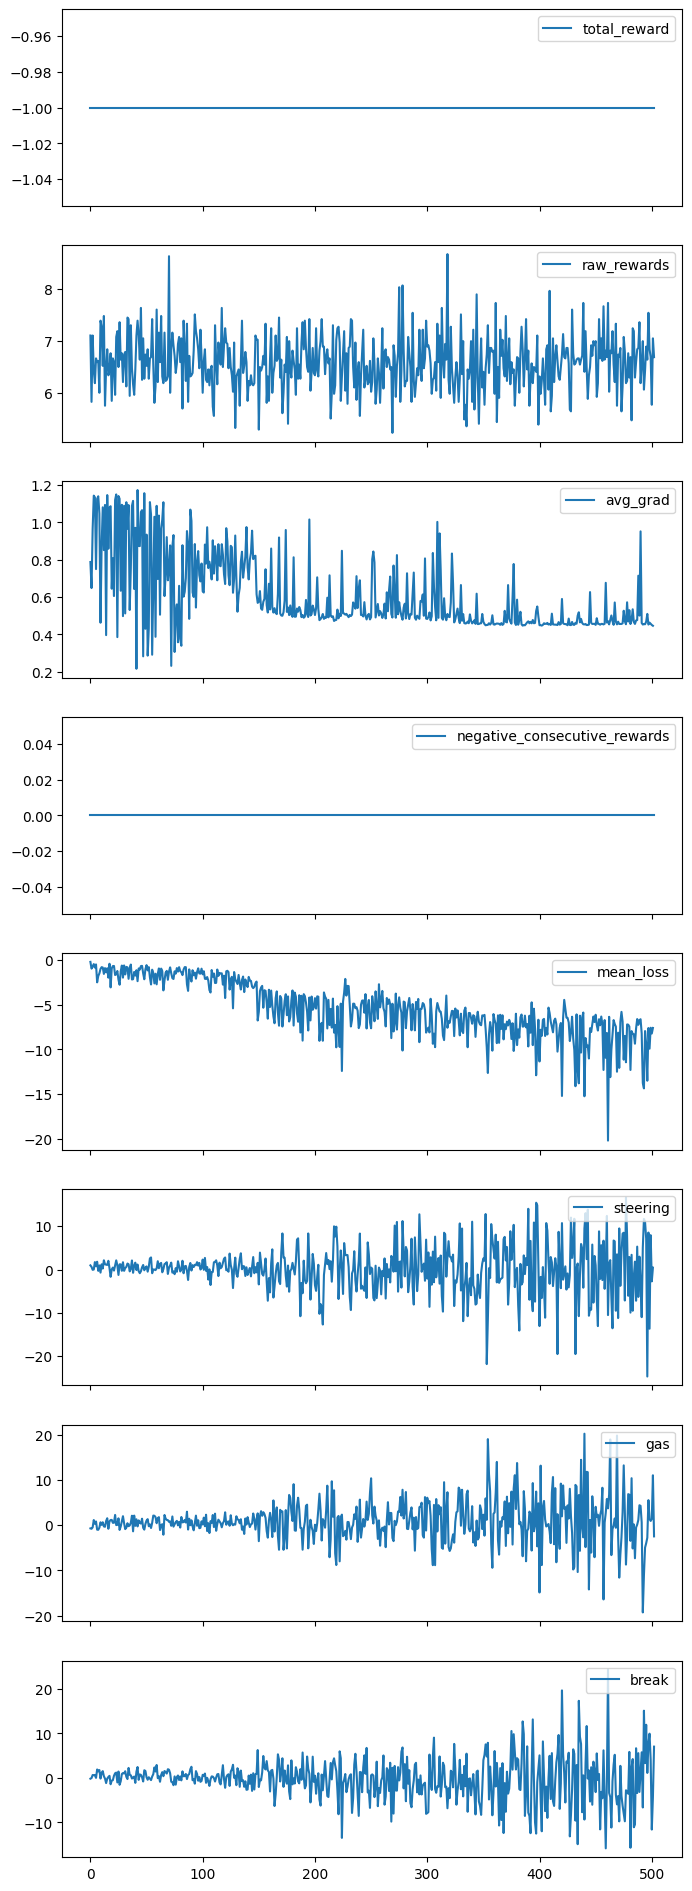

a:  [nan nan nan] 
mean:  tensor([[nan, nan, nan]], grad_fn=<SigmoidBackward0>) 
cov:  tensor([[nan, nan, nan]], grad_fn=<LogBackward0>)


RuntimeError: torch.cat(): expected a non-empty list of Tensors

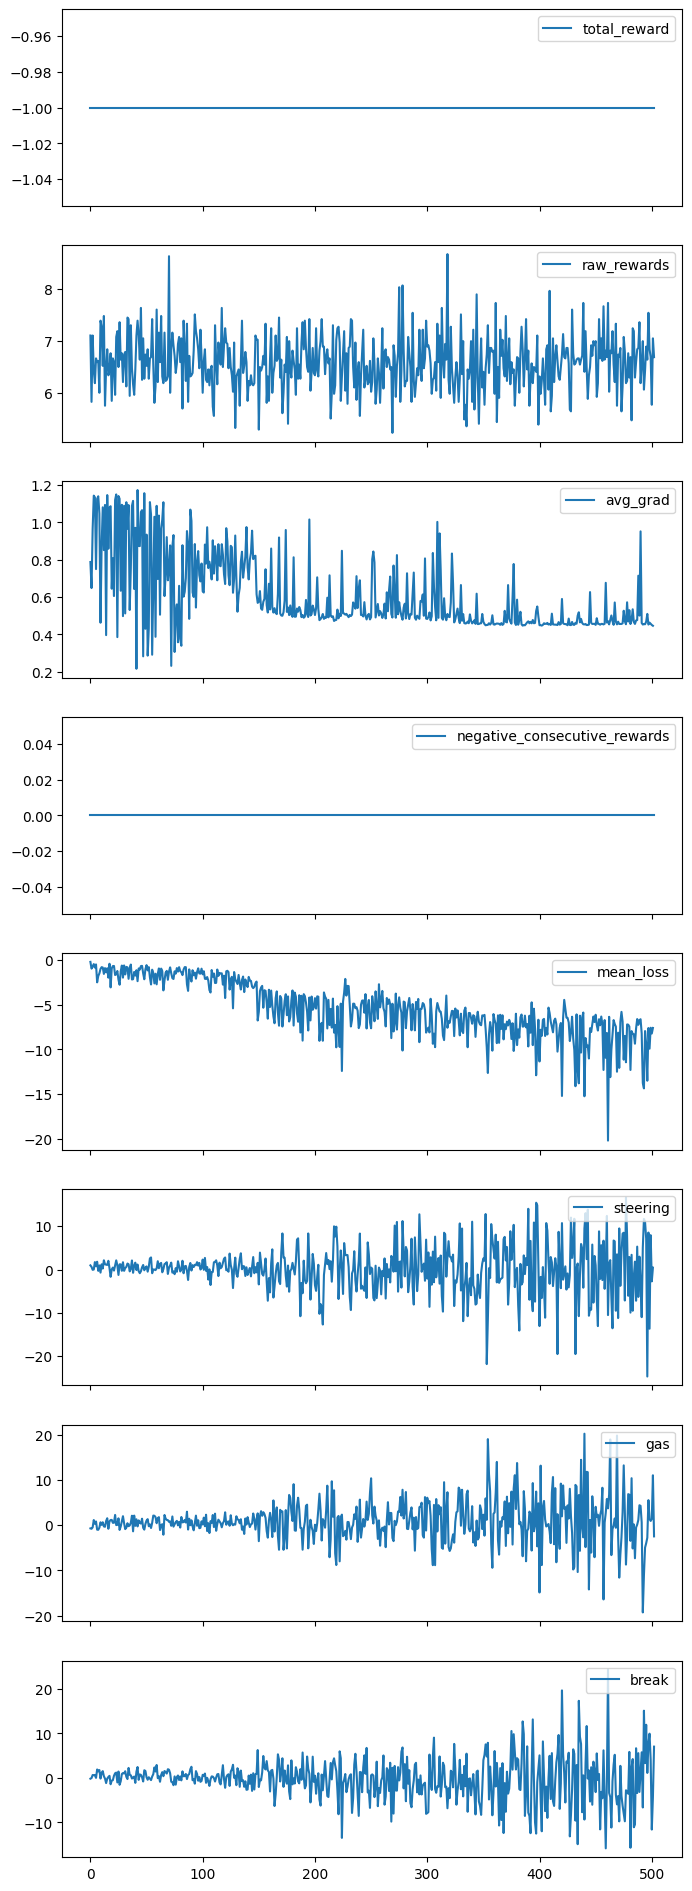

In [4]:
from IPython.display import display, clear_output

import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
# from torch.utils.tensorboard import SummaryWriter
import gymnasium as gym
import torch
import torch.nn.functional as F

from policy_gradient import Policy

# domain_randomize: background and track colours are different on every reset.
env = gym.make("CarRacing-v2", domain_randomize=False, continuous=True)

frame_stack_len = 4
skip_frames = 3
gamma = 0.99

model = Policy(frame_stack_len=frame_stack_len, learning_rate=1e-3)
# model.load_state_dict(torch.load("./checkpoints/policy_gradient/100.pt"))
tensorboard = False

Record = namedtuple("Record", "mean cov v a r")

if tensorboard:
    writer = SummaryWriter()
else:  # use matplotlib in interactive mode.
    metrics = {
        "raw_rewards": [],
        "avg_grad": [], 
        "negative_consecutive_rewards": [],
        "mean_loss": [], 
        "steering": [],
        "gas": [],
        "break": [],
    }
    
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots(len(metrics), 1, sharex=True, figsize=(8, 3*len(metrics)))
    # Initialize line object and legend

    lines = dict()
    for i, k in enumerate(metrics.keys()):
        lines[k], = ax[i].plot([], [], label=k)
        ax[i].legend(loc="upper right")

# n_episodes = 100
n_updates = 200000
pbar = tqdm(total=n_updates)
updates_counter = 0
episode_counter = 0
best_total_reward = 0

while updates_counter < n_updates:
    episode_counter += 1
    obs, info = env.reset()
    s = model.preprocess(obs)
    frame_stack = deque(maxlen=frame_stack_len)
    frame_stack.extend([s for _ in range(frame_stack_len)])  # init with the same state.
    done = False
    t = 1
    total_loss = 0
    total_reward = 0
    raw_reward = 0
    negative_consecutive_rewards = 0
    time_frame_counter = 1

    episode = []

    while not done:  # sample one episode.
        state = torch.concatenate(list(frame_stack), dim=0)
        state = state.unsqueeze(0)  # add batch dim
        mean, cov, v = model.forward(state)
        eps = np.random.normal(0, 1, size=model.n_actions)
        a = mean + torch.sqrt(cov) * torch.tensor(eps, requires_grad=False)
        a = a.flatten()
        a = a.detach().numpy()
        if np.isnan(a).any():
            print("a: ", a, "\nmean: ", mean, "\ncov: ", cov)
            break
        # repeat same action over skip_frames
        for _ in range(skip_frames):
            t += 1
            new_obs, r, terminated, truncated, info = env.step(a)
            raw_reward += r
            done = terminated or truncated
            if done:
                break

        new_s = model.preprocess(new_obs)
        frame_stack.append(new_s)

        new_state = torch.concatenate(list(frame_stack), dim=0)
        new_state = new_state.unsqueeze(0)

        time_frame_counter += 1

        # construct batch.
        episode.append(
            Record(r=r, a=a, mean=mean, cov=cov, v=v),  # reward, log prob of action with gradient
        )
        pbar.update(1)

    
    # perform gradient descent
    model.optimizer.zero_grad()
    gain = torch.tensor([[0.]], requires_grad=False)
    T = len(episode)
    batch = {
        "a": [],
        "cov": [],
        "mean": [],
        "gain": [],
        "v": [],
    }
    for i in range(1, T+1):
        ep = episode[T-i]
        # since we only consider the diagonal of the covariance matrix, we can treat the
        # actions as independent variables.
        a = torch.tensor(ep.a, requires_grad=False).unsqueeze(0)
        batch["a"].append(a)
        batch["mean"].append(ep.mean)
        batch["cov"].append(ep.cov)
        gain = ep.r + gamma * gain
        batch["gain"].append(gain)
        batch["v"].append(ep.v)
    
    for key in batch.keys():
        batch[key] = torch.concat(batch[key])

    # normalize returns.
    # batch["gain"] = (batch["gain"] - batch["gain"].mean())/(batch["gain"].std() + 1e-7)
    log_proba = - (batch["a"] - batch["mean"])**2/(2*batch["cov"]) - 1/2*torch.log(2 * batch["cov"] * torch.pi)
    loss = - (batch["gain"] - batch["v"]) * log_proba + F.mse_loss(batch["v"], batch["gain"])
    loss = loss.sum()
    loss.backward()

    # clip gradient
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
    # get gradient size
    average_gradient_size = model.average_gradient_size()


    # model.scheduler.step()
    model.optimizer.step()

    if tensorboard:
        writer.add_scalar("mean loss", loss.item()/T, episode_counter)
        writer.add_scalar('raw reward', raw_reward, episode_counter)
    else:
        avg_actions = batch["a"].mean(dim=-1)
        steering = avg_actions[0].item()
        gas = avg_actions[1].item()
        break_ = avg_actions[2].item()
        metrics["raw_rewards"].append(raw_reward)
        metrics["negative_consecutive_rewards"].append(negative_consecutive_rewards)
        metrics["avg_grad"].append(average_gradient_size)
        metrics["mean_loss"].append(loss.item()/T)
        metrics["steering"].append(steering)
        metrics["gas"].append(gas)
        metrics["break"].append(break_)
        # Update the data of the line objects
        for key, data in metrics.items():
            lines[key].set_data(range(len(data)), data)
        for i in range(len(ax)):
            ax[i].relim()  # Recalculate limits
            ax[i].autoscale_view(True,True,True)  # Rescale the axis

        clear_output(wait=True)  # Clear the output
        display(fig)  # Re-display the figure

    if total_reward > best_total_reward:
        best_total_reward = total_reward
        torch.save(model.state_dict(), "./checkpoints/policy_gradient/best_model.pt")
    
    if episode_counter % 100 == 0:
        torch.save(model.state_dict(), f"./checkpoints/policy_gradient/{episode_counter}.pt")

if tensorboard:
    writer.close()
else:
    plt.ioff()

env.close()